# Creating an AI app that detects diseases in plants using Facebook’s deep learning framework: PyTorch

# Importing the libraries
First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
import PIL
print(PIL.PILLOW_VERSION)
import warnings
warnings.filterwarnings('ignore')

5.4.1


In [2]:
# We will verify that GPU is enabled for this notebook
# Following should print: CUDA is available!  Training on GPU ...
# if it prints otherwise, CPU will be used.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


# Load the data

Here you'll use 'torchvision'  to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from 'torchvision' were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's ' [0.485, 0.456, 0.406]'  and for the standard deviations ''[0.229, 0.224, 0.225]' , calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [ ]:
# Download the dataset and unzip the folder
# !gdown https://drive.google.com/uc?id=1Bhh3VeMBH6F7vKqHdDDmdyi-7RfvQNqJ
# !tar -xvf PlantVillage.tar.gz

In [3]:
#Organizing the dataset
data_dir = '/output'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

# Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the plant diseases.

In [4]:
import json

with open('categories.json', 'r') as f:
    cat_to_name = json.load(f)
cat_to_name

{'Corn_(maize)___Common_rust_': 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___healthy': 'Corn_(maize)___healthy',
 'Pepper,_bell___Bacterial_spot': 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy': 'Pepper,_bell___healthy',
 'Potato___Early_blight': 'Potato___Early_blight',
 'Potato___healthy': 'Potato___healthy',
 'Tomato___Bacterial_spot': 'Tomato___Bacterial_spot',
 'Tomato___healthy': 'Tomato___healthy'}

In [5]:
# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder
data_dir = 'output'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

In [6]:
class_names

['Corn_(maize)___Common_rust_',
 'Corn_(maize)___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___healthy']

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features. Resnet-152 pretrained model is used for this image classifier.

In [10]:
# 1. Load AlexNet pre-trained network
model = models.alexnet(pretrained=True)
# Freeze parameters so we don't backprop through them

for param in model.parameters():
    param.requires_grad = False

# #Let's check the model architecture:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
from collections import OrderedDict

# Creating the classifier ordered dictionary first
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(9216, 4096)),
                          ('relu', nn.ReLU()),
                          ('dropout_2', nn.Dropout(0.5)),
                          ('fc2', nn.Linear(4096, 8)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
model.classifier = classifier
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu): ReLU()
    (dropout_2): Dr

In [12]:
#Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
# Train a model with a pre-trained network
num_epochs = 20
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Using GPU: True
Epoch 1/15
----------
train Loss: 1.1361 Acc: 0.7908
val Loss: 0.0886 Acc: 0.9740

Epoch 2/15
----------
train Loss: 0.6203 Acc: 0.8514
val Loss: 0.1096 Acc: 0.9740

Epoch 3/15
----------
train Loss: 0.5636 Acc: 0.8693
val Loss: 0.1146 Acc: 0.9706

Epoch 4/15
----------
train Loss: 0.5114 Acc: 0.8703
val Loss: 0.1419 Acc: 0.9678

Epoch 5/15
----------
train Loss: 0.2870 Acc: 0.9195
val Loss: 0.0795 Acc: 0.9805

Epoch 6/15
----------
train Loss: 0.2611 Acc: 0.9243
val Loss: 0.0754 Acc: 0.9808

Epoch 7/15
----------
train Loss: 0.2308 Acc: 0.9302
val Loss: 0.0624 Acc: 0.9832

Epoch 8/15
----------
train Loss: 0.2182 Acc: 0.9360
val Loss: 0.0686 Acc: 0.9836

Epoch 9/15
----------
train Loss: 0.2090 Acc: 0.9364
val Loss: 0.0684 Acc: 0.9843

Epoch 10/15
----------
train Loss: 0.1936 Acc: 0.9439
val Loss: 0.0556 Acc: 0.9846

Epoch 11/15
----------
train Loss: 0.1949 Acc: 0.9435
val Loss: 0.0527 Acc: 0.9846

Epoch 12/15
----------
train Loss: 0.1922 Acc: 0.9460
val Loss: 0.052

In [14]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['val']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['val'])))

In [15]:
test(model, dataloaders, device)

Testing Accuracy: 0.002
Testing Accuracy: 0.003
Testing Accuracy: 0.005
Testing Accuracy: 0.006
Testing Accuracy: 0.008
Testing Accuracy: 0.010
Testing Accuracy: 0.012
Testing Accuracy: 0.013
Testing Accuracy: 0.015
Testing Accuracy: 0.017
Testing Accuracy: 0.018
Testing Accuracy: 0.020
Testing Accuracy: 0.022
Testing Accuracy: 0.024
Testing Accuracy: 0.025
Testing Accuracy: 0.027
Testing Accuracy: 0.029
Testing Accuracy: 0.030
Testing Accuracy: 0.032
Testing Accuracy: 0.034
Testing Accuracy: 0.035
Testing Accuracy: 0.037
Testing Accuracy: 0.039
Testing Accuracy: 0.040
Testing Accuracy: 0.042
Testing Accuracy: 0.044
Testing Accuracy: 0.045
Testing Accuracy: 0.047
Testing Accuracy: 0.049
Testing Accuracy: 0.051
Testing Accuracy: 0.052
Testing Accuracy: 0.054
Testing Accuracy: 0.056
Testing Accuracy: 0.057
Testing Accuracy: 0.059
Testing Accuracy: 0.061
Testing Accuracy: 0.062
Testing Accuracy: 0.064
Testing Accuracy: 0.066
Testing Accuracy: 0.067
Testing Accuracy: 0.069
Testing Accuracy

# Save the checkpoint

Now that the network is trained,  we will save the model so we can load it later for making predictions. We will save the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. We will attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that we'll want to completely rebuild the model later so we can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [16]:
# Save the checkpoint 
model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 8,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, 'alexnet_output.pth')

# Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [14]:
#Download the trained model from here: 
# !gdown https://drive.google.com/uc?id=1D3mWC5AAWlx3OdU4yljt7vtEPrpLFtmZ

In [7]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.alexnet()
    
    # Our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 8
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(9216, 4096)),
                          ('relu', nn.ReLU()),
                          ('dropout_2', nn.Dropout(0.5)),
                          ('fc2', nn.Linear(4096, 8)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

    # Replacing the pretrained model classifier with our classifier
    model.classifier = classifier
    # print(checkpoint)
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('alexnet_output.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

loaded_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu): ReLU()
    (dropout_2): Dr

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the plant disease in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 


In [8]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [9]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']

In [10]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

In [12]:
print (predict('output/val/Potato___healthy/2d98cbc8-cbe6-423c-b2ab-3f7f8bcea5d5___RS_HL 1945.JPG', loaded_model))

(array([9.9992204e-01, 7.7866178e-05, 7.0653989e-08, 2.5400311e-08,
       1.7953474e-09], dtype=float32), ['Potato___healthy', 'Pepper,_bell___healthy', 'Pepper,_bell___Bacterial_spot', 'Potato___Early_blight', 'Tomato___healthy'])


# Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

You can convert from the class integer encoding to actual plant diseases names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [45]:
# Display an image along with the top 5 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapper[img_filename]
    
    ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

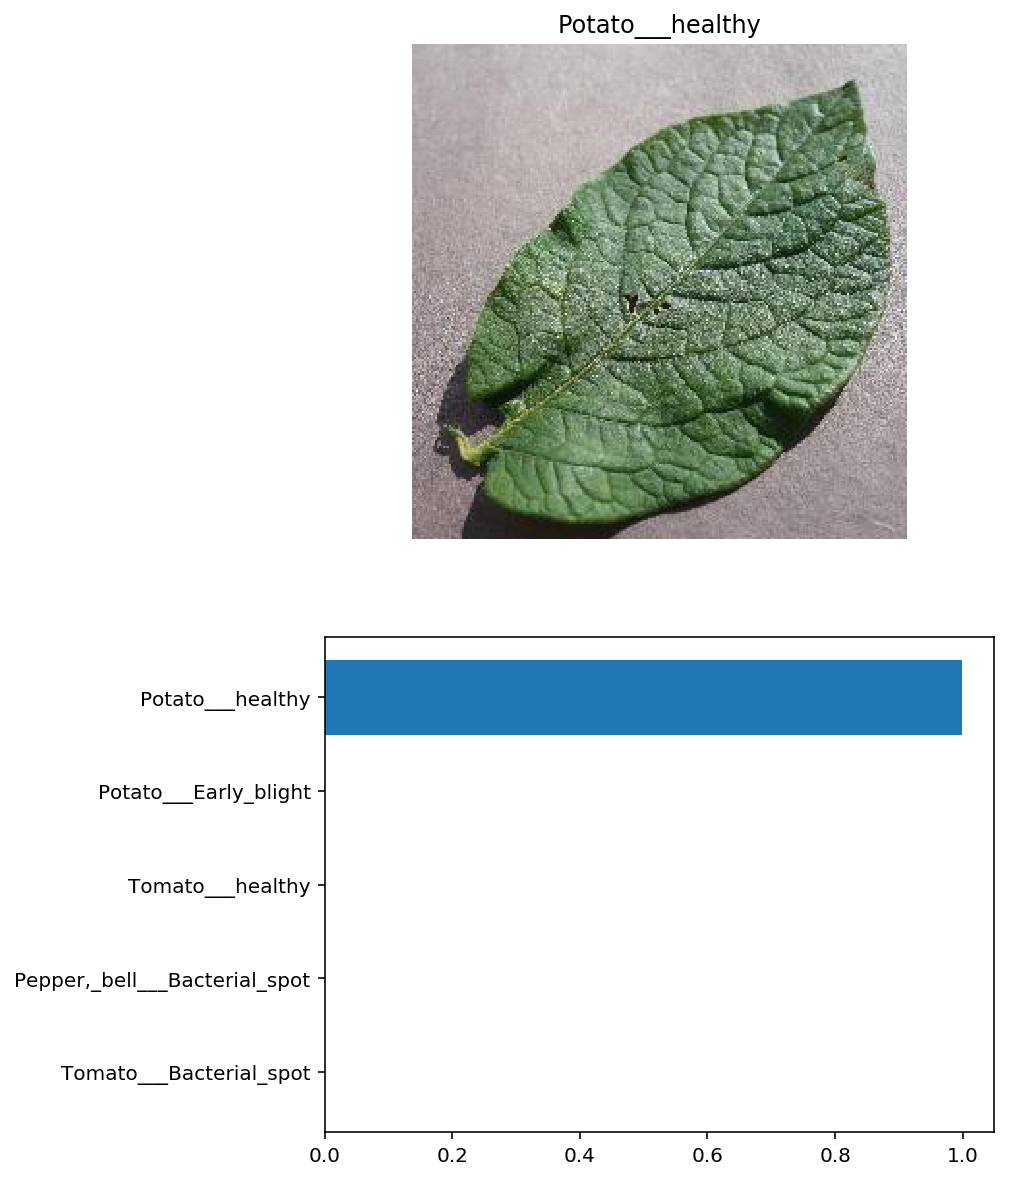

In [46]:
img = 'output/test/Potato___healthy/a3ec91aa-8503-4711-a912-0d1427e25686___RS_HL 5409.JPG'

p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

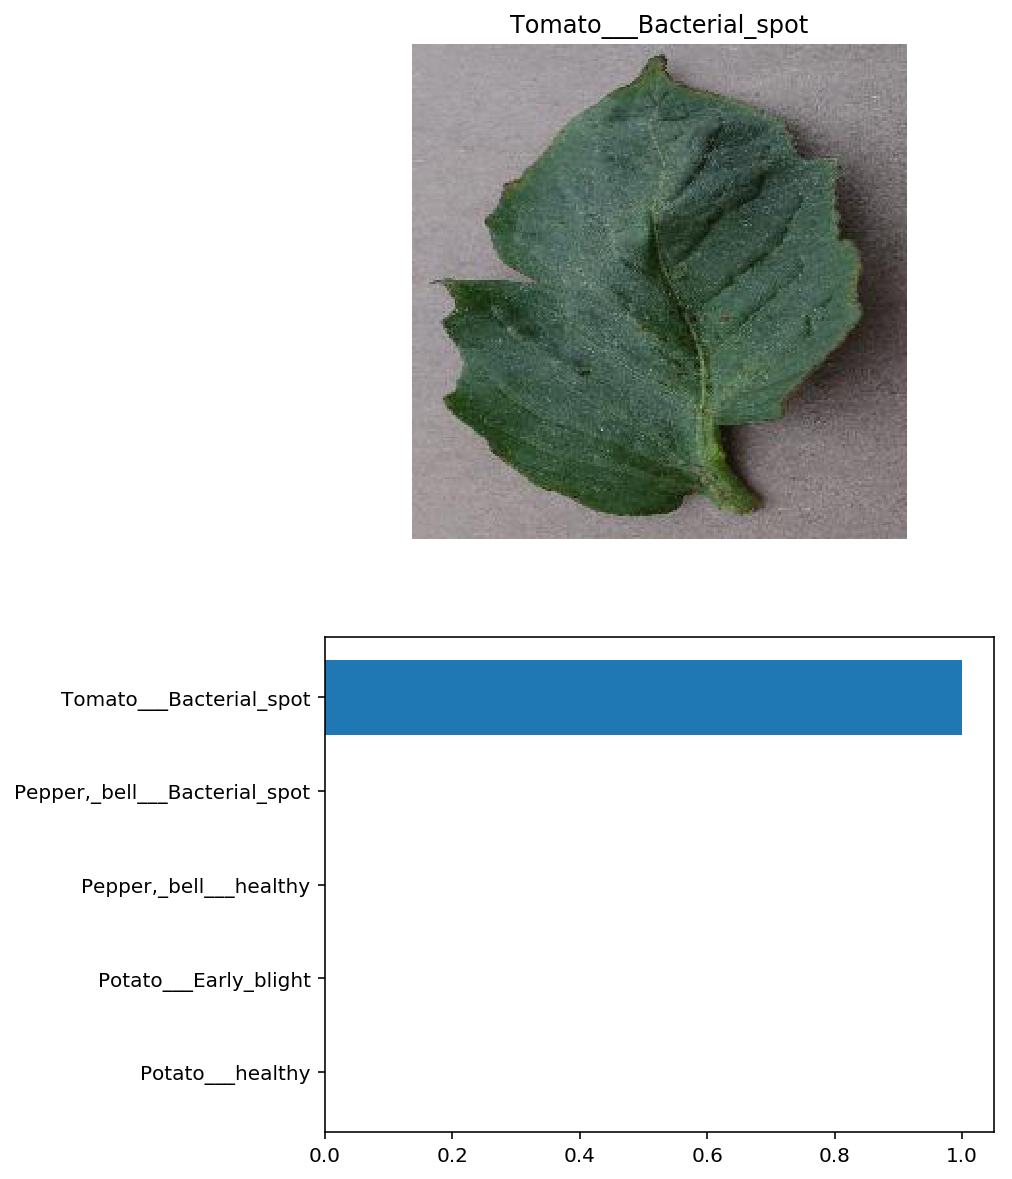

In [78]:
img = 'output/val/Tomato___Bacterial_spot/03ca5883-e9d6-4f88-81d8-90176fcc5413___GCREC_Bact.Sp 3013.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

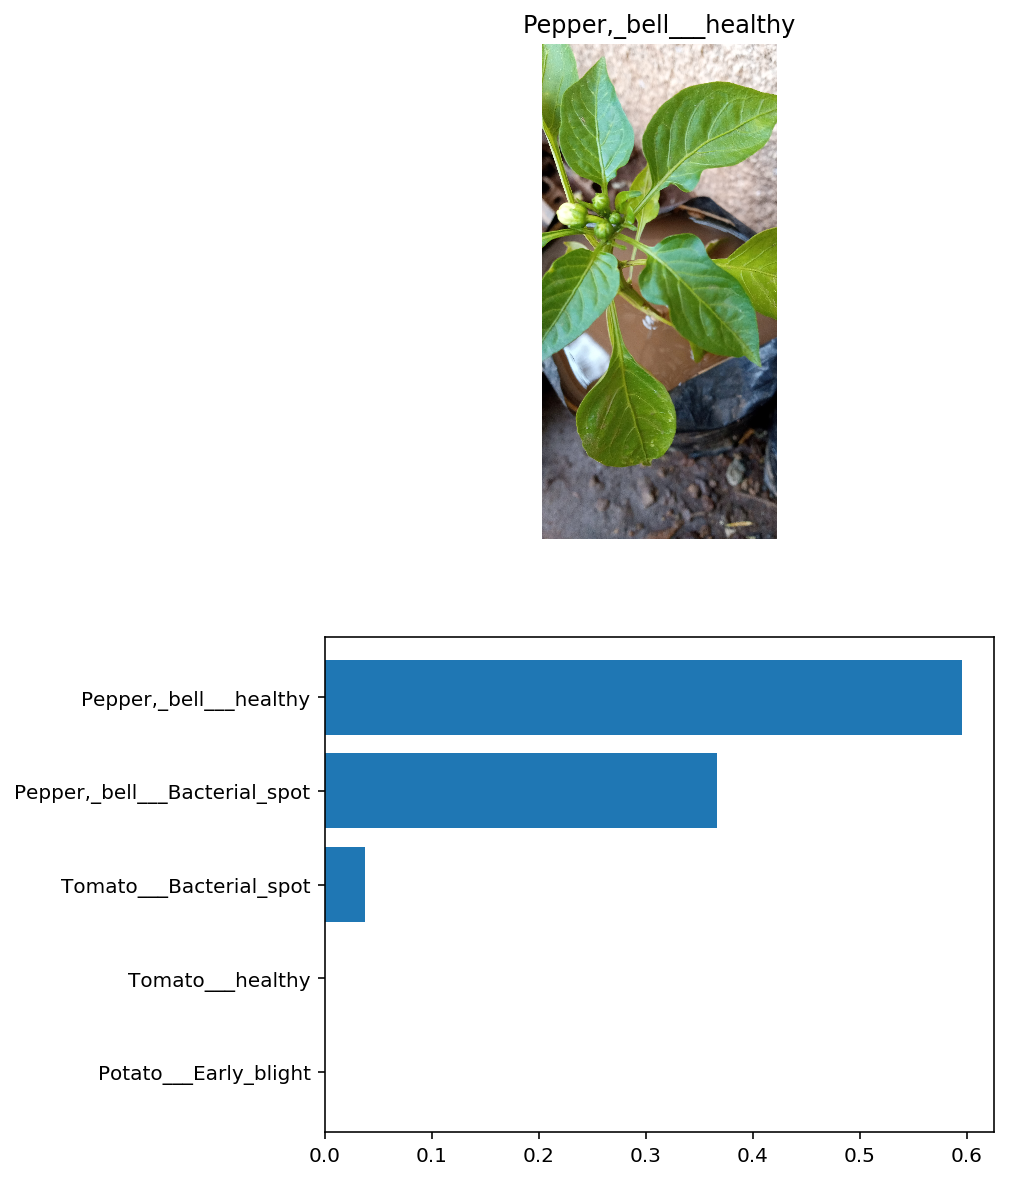

In [79]:
img = 'output/test/Pepper,_bell___healthy/4.JPG'
# 1_copy
# img = 'output/newdata/Pepper,_bell___healthy/3.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

torch.Size([1, 3, 224, 224])
[3.8965493e-09 5.9537203e-10 9.6930671e-01 3.0661443e-02 4.6401465e-06
 1.2689127e-07 2.7162976e-05 3.7326586e-09]


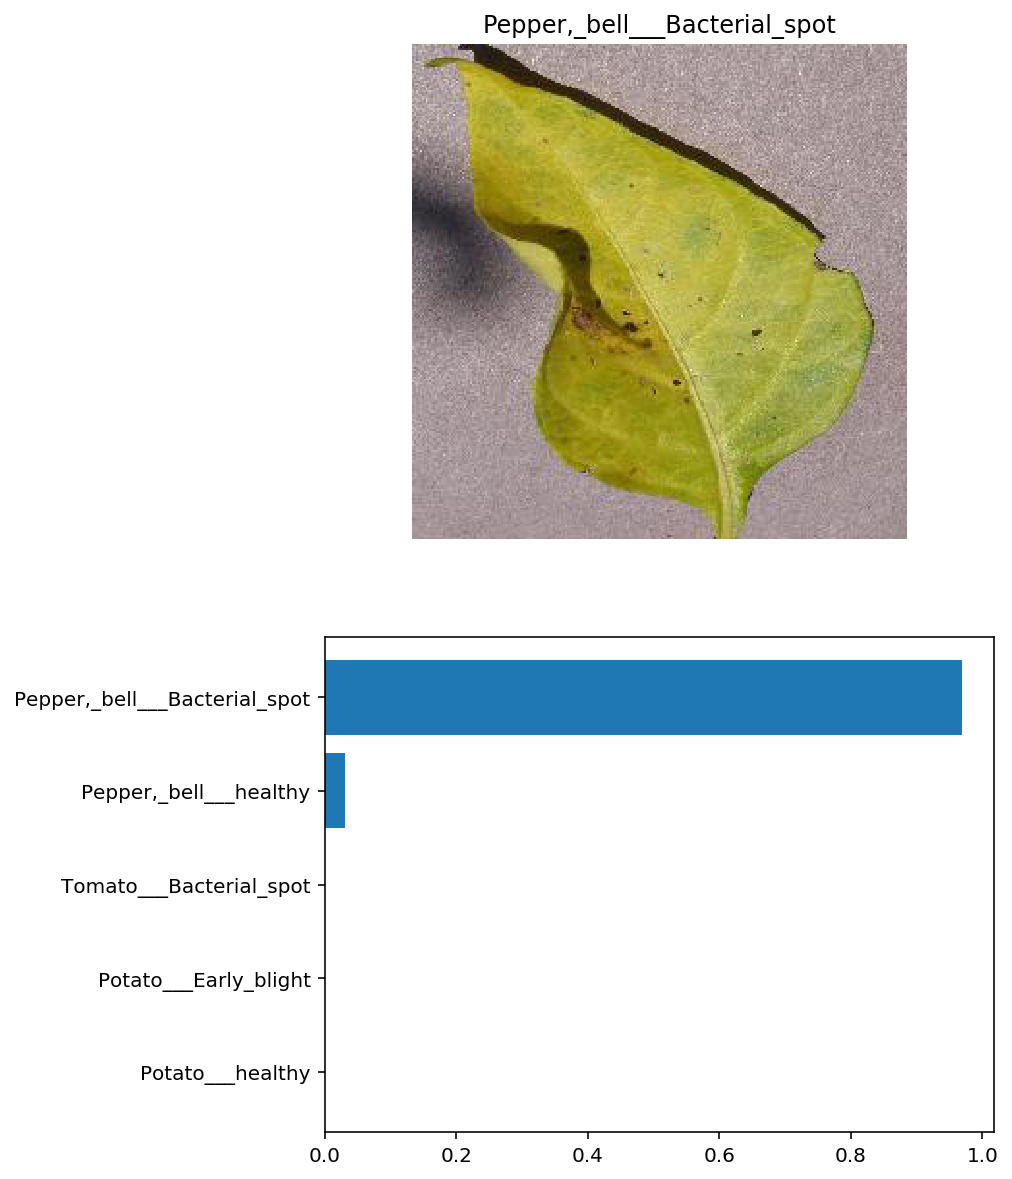

In [71]:
img = 'output/test/Pepper,_bell___Bacterial_spot/e67a8a4a-e383-4eee-95e8-22443071ed6d___JR_B.Spot 9057.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

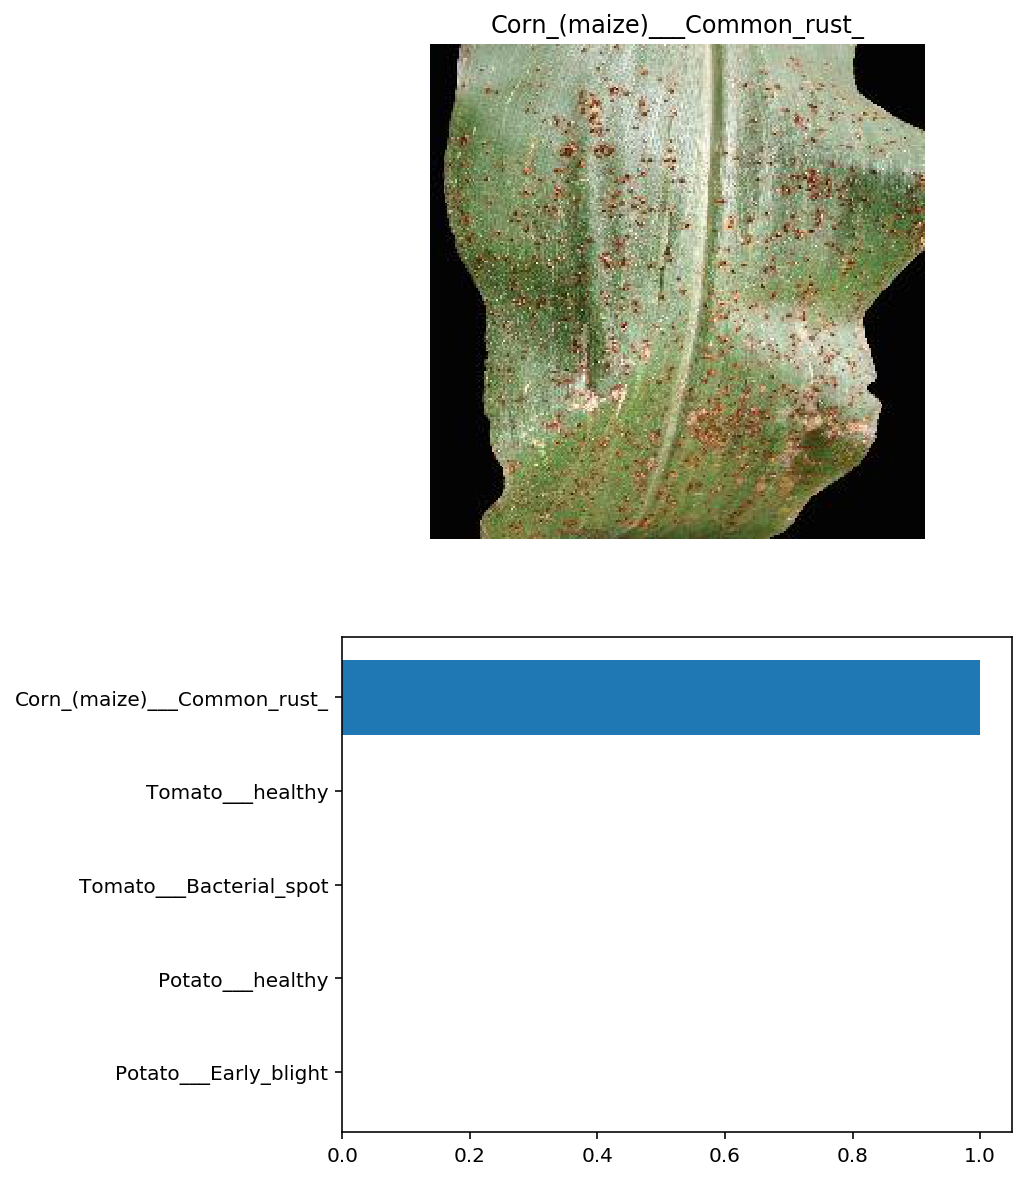

In [36]:
img = 'output/test/Corn_(maize)___Common_rust_/image.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

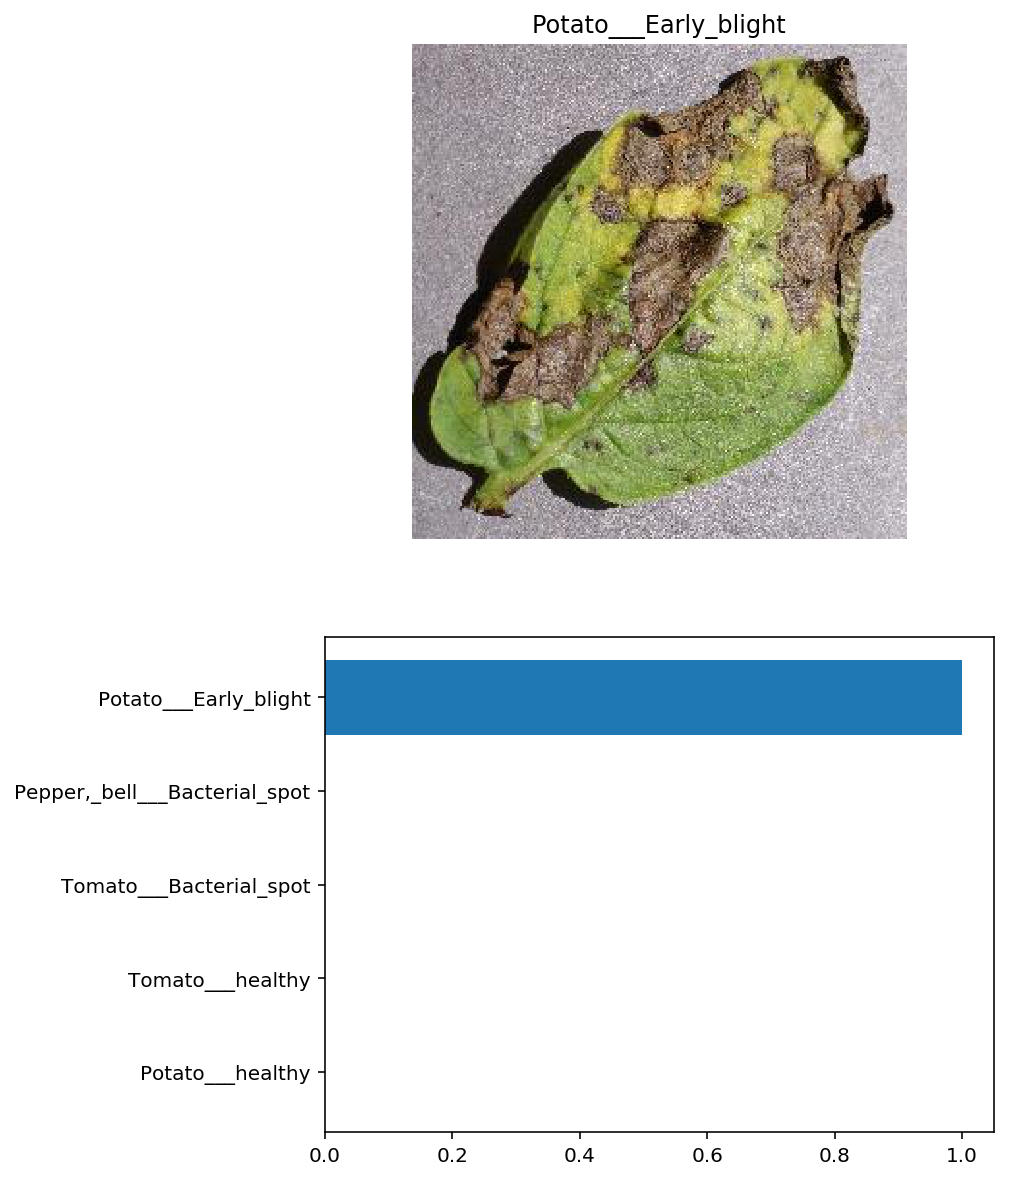

In [29]:
img = 'output/test/Potato___Early_blight/f20b88af-30e2-4270-a035-2cf217469cf8___RS_Early.B 8266.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)